# 필요한 모듈 설치

In [ ]:
%pip install tqdm
%pip install lightgbm
%pip install easydict
%pip install koreanize-matplotlib

In [ ]:
# 1. 시스템 및 환경 관련 라이브러리
import os
import random
import tqdm

# 2. 데이터 분석 및 처리 라이브러리
import pandas as pd
import numpy as np
import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 3. 머신러닝 관련 라이브러리
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    StratifiedKFold  # ✅ StratifiedKFold 추가
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix  # ✅ confusion_matrix 추가
from sklearn.model_selection import cross_val_score

# LightGBM 라이브러리
import lightgbm as lgb

# 날짜 및 시간 관련 라이브러리
from datetime import datetime, timezone, timedelta

# 한국 시간대 설정
kst = timezone(timedelta(hours=9))

today = datetime.now(kst).strftime('%m%d')

def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [3]:
import pandas as pd
from pathlib import Path

def load_data():
    # 데이터 폴더 경로 설정
    data_path = Path("data/")
    file_path = data_path / "customer_churn_telecom_services.csv"  # CSV 파일 경로

    # 파일이 존재하는지 확인
    if not file_path.exists():
        raise FileNotFoundError(f"파일이 존재하지 않습니다: {file_path}")

    # CSV 파일 로드
    df = pd.read_csv(file_path)
    return df  # DataFrame 반환

# ✅ 사용 예시
data = load_data()
print(data.head())  # 데이터 확인


   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No  

In [4]:
import os
import easydict
from pathlib import Path

args = easydict.EasyDict()

# ✅ 로컬 경로 설정 (VS Code에서는 로컬 PC 경로를 사용)
args.default_path = Path("C:/dev/github/SKN10-2nd-3Team-1/data")  
args.data_csv = args.default_path / "customer_churn_telecom_services.csv"

# ✅ 결과 저장 경로 (로컬 PC에 저장할 경로)
history_results_dir = Path("C:/dev/github/SKN10-2nd-3Team-1/")
history_results_path = history_results_dir / "history_results.csv"

# 기타 설정
args.random_seed = 42
args.results = []  # 결과 저장 리스트

# ✅ 경로 확인
print(f"데이터 파일 경로: {args.data_csv}")
print(f"결과 저장 경로: {history_results_path}")

데이터 파일 경로: C:\dev\github\SKN10-2nd-3Team-1\data\customer_churn_telecom_services.csv
결과 저장 경로: C:\dev\github\SKN10-2nd-3Team-1\history_results.csv


# Model V2

In [5]:
ori_data=pd.read_csv(args.data_csv)
ori_data.shape

(7043, 20)

In [6]:
ori_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
ori_data.columns, len(ori_data.columns)

(Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
        'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
        'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
        'MonthlyCharges', 'TotalCharges', 'Churn'],
       dtype='object'),
 20)

In [8]:
# train 데이터와 test 데이터로 나눔
reset_seeds()
ori_tr, ori_te = train_test_split(ori_data, test_size=0.2, stratify=ori_data['Churn'], random_state=args.random_seed)

ori_tr.shape,ori_te.shape

((5634, 20), (1409, 20))

In [9]:
# ori_tr을 학습용과 검증용으로 나눔
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['Churn'], random_state=args.random_seed)

train.shape,test.shape      # train은 학습용, test는 검증용

((4507, 20), (1127, 20))

In [10]:
ori_tr.isnull().sum().sort_values(ascending=False)   # 결측치 확인

TotalCharges        8
gender              0
Partner             0
SeniorCitizen       0
Dependents          0
tenure              0
MultipleLines       0
PhoneService        0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
InternetService     0
TechSupport         0
StreamingTV         0
Contract            0
StreamingMovies     0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
Churn               0
dtype: int64

In [11]:
# 결측치 제거

# ori_te는 나중에 테스트 할 데이터
median_value_ori_te = ori_te["TotalCharges"].median()
ori_te['TotalCharges'].fillna(median_value_ori_te, inplace=True)
# train은 ori_tr중 학습용으로 나눈 데이터
median_value_train = train["TotalCharges"].median()
train['TotalCharges'].fillna(median_value_train, inplace=True)
# test는 ori_tr중 검증용으로 나눈 데이터
median_value_test = test["TotalCharges"].median()
test['TotalCharges'].fillna(median_value_test, inplace=True)

ori_te.isnull().sum().sum(), train.isnull().sum().sum(), test.isnull().sum().sum()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_12544\1157671122.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ori_te['TotalCharges'].fillna(median_value_ori_te, inplace=True)
C:\Users\Playdata\AppData\Local\Temp\ipykernel_12544\1157671122.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

(np.int64(0), np.int64(0), np.int64(0))

# 특성 정리
  - 고객 특성 관련
    - Gender (성별)
    - SeniorCitizen (고령자 여부)
    - Partner (배우자 여부)
    - Dependents (부양가족 여부)
    - Tenure (가입 기간)
  - 서비스 이용 관련
    - PhoneService (전화 서비스 여부)
    - MultipleLines (복수 전화선 여부)
    - InternetService (인터넷 서비스 유형)
    - OnlineSecurity (온라인 보안 서비스 여부)
    - OnlineBackup (온라인 백업 서비스 여부)
    - DeviceProtection (디바이스 보호 서비스 여부)
    - TechSupport (기술 지원 서비스 여부)
    - StreamingTV (TV 스트리밍 서비스 여부)
    - StreamingMovies (영화 스트리밍 서비스 여부)
  - 계약 & 요금 관련
    - Contract (계약 유형)
    - PaperlessBilling (전자 청구서 여부) (Yes: 사용, No: 미사용)
    - PaymentMethod (결제 방식) (Electronic check: 전자 수표, Mailed check: 우편 수표, Other: 자동 이체 또는 신용카드)
    - MonthlyCharges (월 요금)
    - TotalCharges (총 청구 금액)

In [12]:
train.nunique(axis=0)

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1390
TotalCharges        4267
Churn                  2
dtype: int64

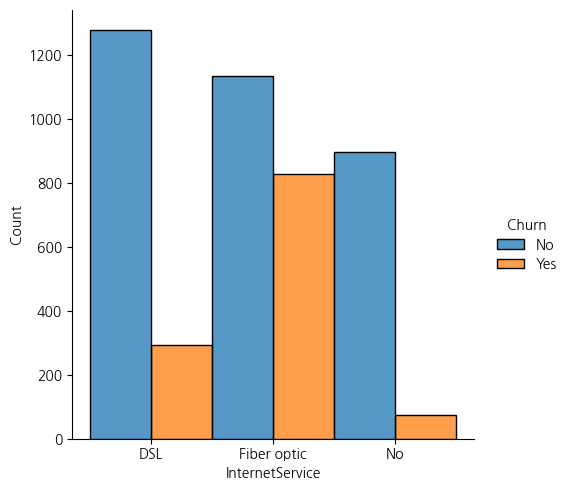

In [13]:
# 이탈자는 대부분 Fiber optic에서 발생
sns.displot(train, x="InternetService", hue="Churn", multiple="dodge", bins=20)

In [14]:
# Fiber optic이면 1, 아니면 0으로 변환 ( Fiber optic 서비스 이용자와 아닌 사람들로 새로 특성 만듦 )
train["Fiber_Optic"] = (train["InternetService"] == "Fiber optic").astype(int)
# test와 ori_te 에도 똑같이 적용
test["Fiber_Optic"] = (test["InternetService"] == "Fiber optic").astype(int)
ori_te["Fiber_Optic"] = (ori_te["InternetService"] == "Fiber optic").astype(int)
train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Fiber_Optic
6592,Male,0,No,No,26,Yes,No,DSL,No,No,...,Yes,Yes,No,One year,No,Credit card (automatic),59.45,1507.00,No,0
464,Male,1,Yes,No,72,Yes,Yes,Fiber optic,Yes,Yes,...,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),116.05,8404.90,No,1
5420,Male,0,Yes,No,70,Yes,Yes,Fiber optic,Yes,Yes,...,Yes,Yes,Yes,Two year,No,Credit card (automatic),114.30,8244.30,No,1
629,Male,1,Yes,No,49,Yes,Yes,Fiber optic,No,Yes,...,No,No,Yes,Month-to-month,No,Credit card (automatic),90.05,4547.25,Yes,1
431,Female,0,Yes,Yes,72,No,No phone service,DSL,Yes,Yes,...,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),65.20,4784.45,No,0


In [15]:
# Fiber_Optic 새로 만들었으므로 기존 컬럼 삭제
train.drop(["InternetService"], axis=1, inplace=True)
test.drop(["InternetService"], axis=1, inplace=True)
ori_te.drop(["InternetService"], axis=1, inplace=True)
train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Fiber_Optic
6592,Male,0,No,No,26,Yes,No,No,No,No,Yes,Yes,No,One year,No,Credit card (automatic),59.45,1507.00,No,0
464,Male,1,Yes,No,72,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),116.05,8404.90,No,1
5420,Male,0,Yes,No,70,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),114.30,8244.30,No,1
629,Male,1,Yes,No,49,Yes,Yes,No,Yes,No,No,No,Yes,Month-to-month,No,Credit card (automatic),90.05,4547.25,Yes,1
431,Female,0,Yes,Yes,72,No,No phone service,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),65.20,4784.45,No,0


# 이탈이 많이 발생하는 경우들 정리 ( 문제점 파악 )
    - Fiber_Optic 사용자, 계약 지속 기간, 요금 지불 방법, 계약 유형이 Month-to-month인 경우

- Fiber_Optic이 요금이 더 비쌈 그 가격대에 맞는 만족스러운 서비스가 안이뤄졌을것이라 예상 ( 가격을 낮추거나 서비스의 질을 올리는 경우 생각해봐야함)

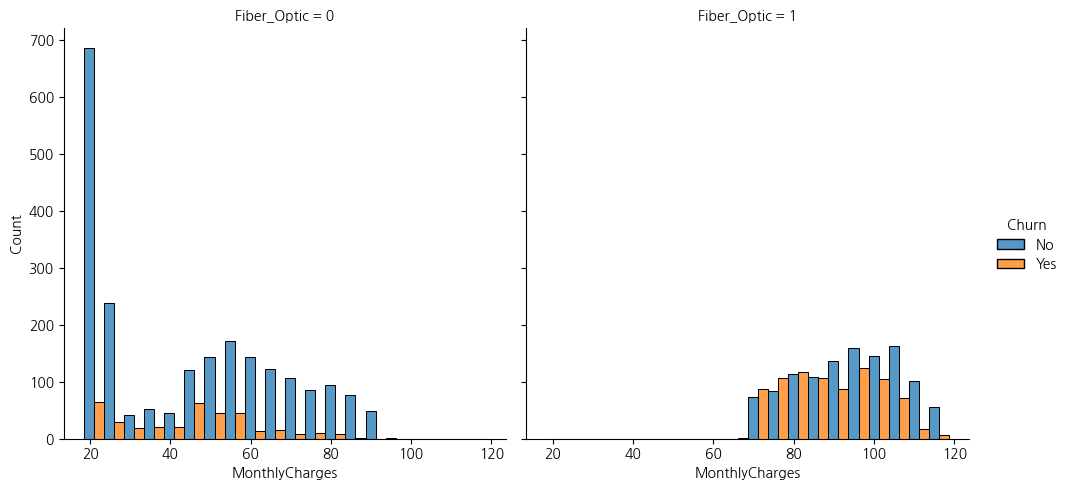

In [16]:
# Fiber_Optic 서비스 이용자와 아닌 그룹간의 월별 요금 비교
sns.displot(train, x="MonthlyCharges", hue="Churn", multiple="dodge", bins=20, col="Fiber_Optic")

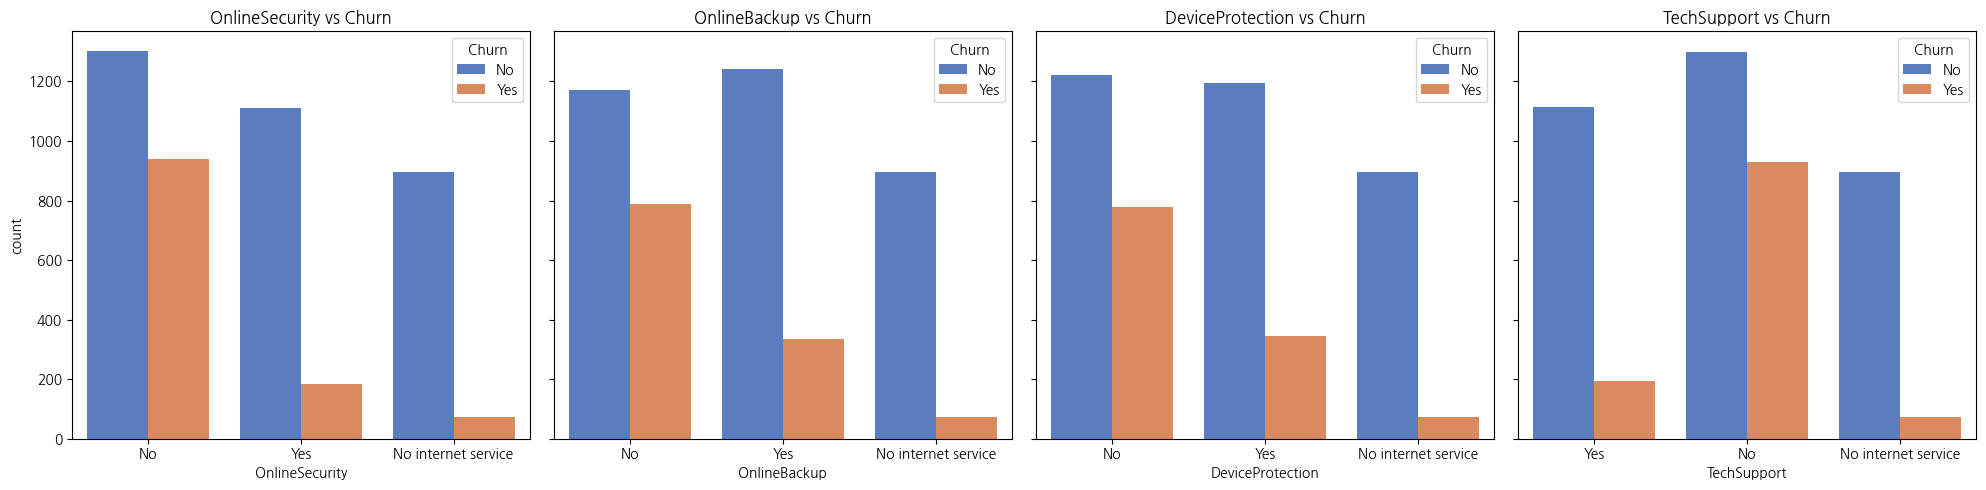

In [17]:
# 원하는 컬럼 리스트
cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport"]

# 그래프 크기 설정
fig, axes = plt.subplots(1, len(cols), figsize=(20, 5), sharey=True)

# 각 컬럼별로 그래프 생성
for col, ax in zip(cols, axes):
    sns.countplot(data=train, x=col, hue="Churn", palette="muted", ax=ax)
    ax.set_title(f"{col} vs Churn")

plt.tight_layout()
plt.show()

# "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport" 이 서비스들은 No인 경우 이탈률이 높음 
# -> 서비스 퀄리티 문제는 아니라고 생각됨


- "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport" 이 서비스들은 No인 경우 이탈률이 높음 
- -> 서비스 퀄리티 문제는 아니라고 생각됨

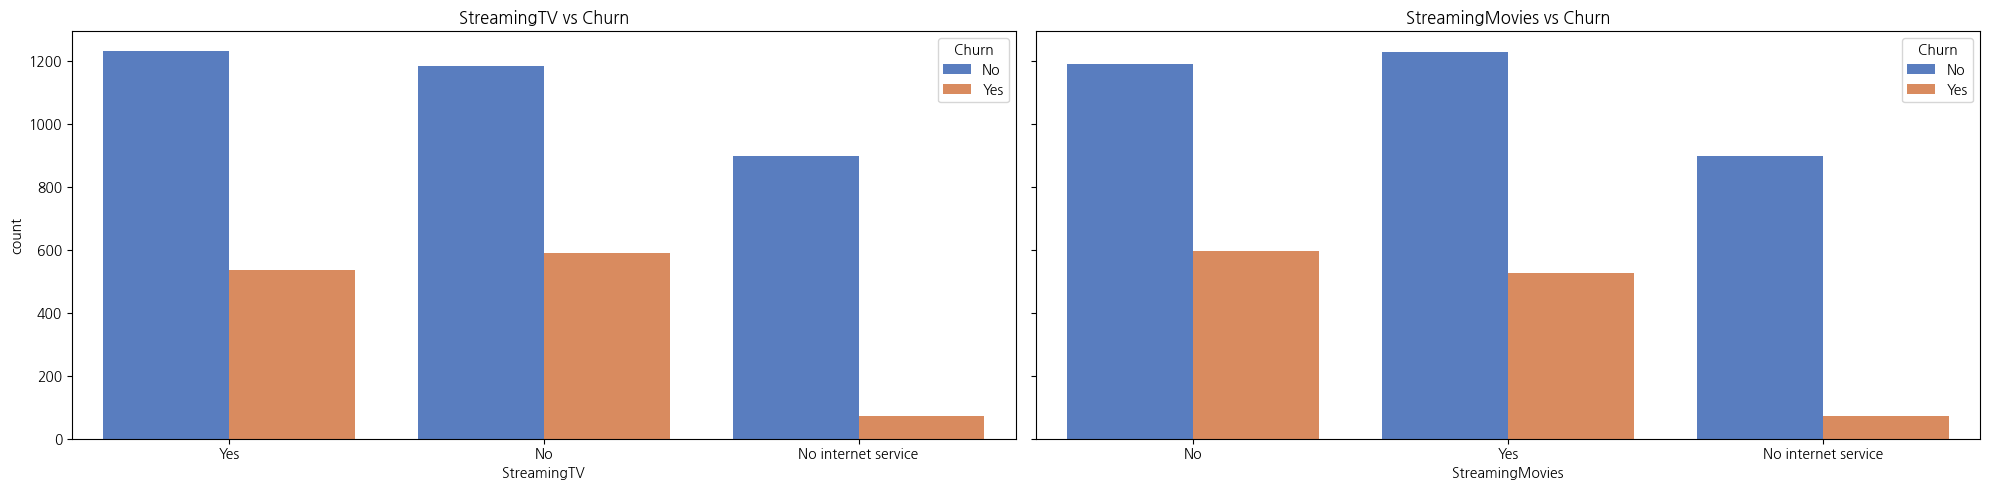

In [ ]:
cols = ["StreamingTV", "StreamingMovies"]

# 그래프 크기 설정
fig, axes = plt.subplots(1, len(cols), figsize=(20, 5), sharey=True)

# 각 컬럼별로 그래프 생성
for col, ax in zip(cols, axes):
    sns.countplot(data=train, x=col, hue="Churn", palette="muted", ax=ax)
    ax.set_title(f"{col} vs Churn")

plt.tight_layout()
plt.show()

# - streaming 관련 서비스들은 이용하는 그룹과 아닌 그룹의 이탈률이 비슷했다 
# -> streaming 서비스는 이탈에 큰 영향을 주지 않는다 판단

- streaming 관련 서비스들은 이용하는 그룹과 아닌 그룹의 이탈률이 비슷했다 
- -> streaming 서비스는 이탈에 큰 영향을 주지 않는다 판단

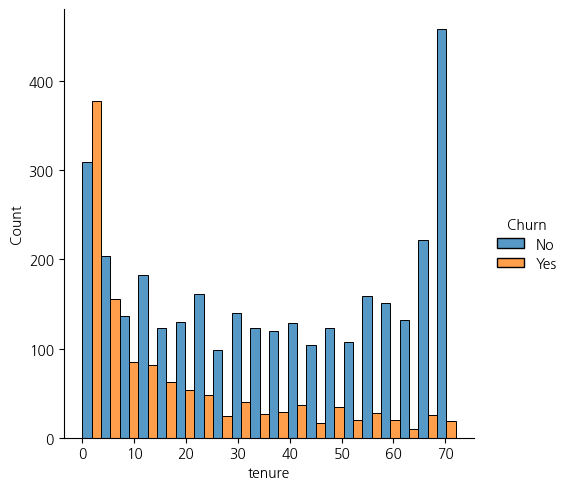

In [43]:
# 계약 기간이 짧을수록 이탈률 증가, 길수록 감소
sns.displot(train, x="tenure", hue="Churn", multiple="dodge", bins=20)

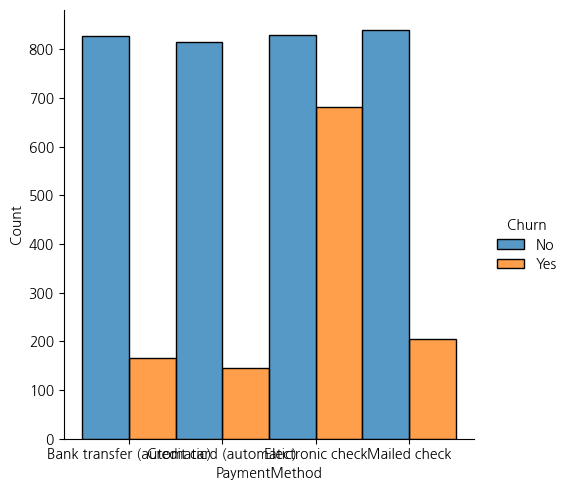

In [44]:
# 지불 방법이 자동 결제 아닌 경우에 이탈률이 많았음
sns.displot(train, x="PaymentMethod", hue="Churn", multiple="dodge", bins=20)

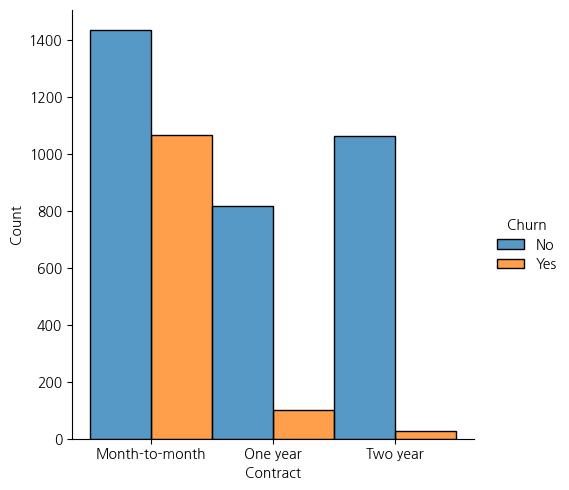

In [45]:
# 계약이 1년이나 2년 단위보다 Month-to-month인 경우 이탈률이 급증함
sns.displot(train, x="Contract", hue="Churn", multiple="dodge", bins=20)

# 문제 해결 방법
    - 계약을 년 단위로 하는 경우 요금을 낮춰주거나 하는 방식으로 계약 기간을 길게 가져가면서 가격을 낮춰서 부담을 덜어준다
    - 요금 지불 방법을 자동결제로 바꾸도록 유도한다

# 컬럼 조합 및 수정

In [22]:
train["No_Phoneservice"] = (train["PhoneService"] == 0).astype(int)
train[["PhoneService", "No_Phoneservice"]].head()

,PhoneService,No_Phoneservice
6592,Yes,0
464,Yes,0
5420,Yes,0
629,Yes,0
431,No,0


In [23]:
# train과 ori_te에도 똑같이 적용
test["No_Phoneservice"] = (test["PhoneService"] == 0).astype(int)
ori_te["No_Phoneservice"] = (ori_te["PhoneService"] == 0).astype(int)

In [24]:
train["No_Multiple"] = ((train["PhoneService"] == 1) & (train["MultipleLines"] == "No")).astype(int)

train[["PhoneService", "MultipleLines", "No_Multiple"]].head()

,PhoneService,MultipleLines,No_Multiple
6592,Yes,No,0
464,Yes,Yes,0
5420,Yes,Yes,0
629,Yes,Yes,0
431,No,No phone service,0


In [25]:
test["Multiple"] = ((test["PhoneService"] == 1) & (test["MultipleLines"] == "Yes")).astype(int)
ori_te["Multiple"] = ((ori_te["PhoneService"] == 1) & (ori_te["MultipleLines"] == "Yes")).astype(int)
train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Fiber_Optic,No_Phoneservice,No_Multiple
6592,Male,0,No,No,26,Yes,No,No,No,No,...,No,One year,No,Credit card (automatic),59.45,1507.00,No,0,0,0
464,Male,1,Yes,No,72,Yes,Yes,Yes,Yes,Yes,...,Yes,Two year,Yes,Bank transfer (automatic),116.05,8404.90,No,1,0,0
5420,Male,0,Yes,No,70,Yes,Yes,Yes,Yes,Yes,...,Yes,Two year,No,Credit card (automatic),114.30,8244.30,No,1,0,0
629,Male,1,Yes,No,49,Yes,Yes,No,Yes,No,...,Yes,Month-to-month,No,Credit card (automatic),90.05,4547.25,Yes,1,0,0
431,Female,0,Yes,Yes,72,No,No phone service,Yes,Yes,Yes,...,Yes,Two year,Yes,Credit card (automatic),65.20,4784.45,No,0,0,0


In [26]:
# 범주형
cat_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

# 연속형
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']

In [27]:
# object 데이터들을 category로 변환
for df in [train, test, ori_te]:
    df[cat_features] = df[cat_features].astype('category')

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4507 entries, 6592 to 6352
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            4507 non-null   category
 1   SeniorCitizen     4507 non-null   int64   
 2   Partner           4507 non-null   category
 3   Dependents        4507 non-null   category
 4   tenure            4507 non-null   int64   
 5   PhoneService      4507 non-null   category
 6   MultipleLines     4507 non-null   category
 7   OnlineSecurity    4507 non-null   category
 8   OnlineBackup      4507 non-null   category
 9   DeviceProtection  4507 non-null   category
 10  TechSupport       4507 non-null   category
 11  StreamingTV       4507 non-null   category
 12  StreamingMovies   4507 non-null   category
 13  Contract          4507 non-null   category
 14  PaperlessBilling  4507 non-null   category
 15  PaymentMethod     4507 non-null   category
 16  MonthlyCharges    4507 non

In [28]:
# 인코딩 하면서 Auto끼리 묶고 check 끼리 묶어줌
train['AutoPayment'] = train['PaymentMethod'].replace({
    'Credit card (automatic)': 1,
    'Bank transfer (automatic)': 1,
    'Electronic check': 0,
    'Mailed check': 0
})
train.head()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_12544\2499437404.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['AutoPayment'] = train['PaymentMethod'].replace({
C:\Users\Playdata\AppData\Local\Temp\ipykernel_12544\2499437404.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  train['AutoPayment'] = train['PaymentMethod'].replace({


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Fiber_Optic,No_Phoneservice,No_Multiple,AutoPayment
6592,Male,0,No,No,26,Yes,No,No,No,No,...,One year,No,Credit card (automatic),59.45,1507.00,No,0,0,0,1
464,Male,1,Yes,No,72,Yes,Yes,Yes,Yes,Yes,...,Two year,Yes,Bank transfer (automatic),116.05,8404.90,No,1,0,0,1
5420,Male,0,Yes,No,70,Yes,Yes,Yes,Yes,Yes,...,Two year,No,Credit card (automatic),114.30,8244.30,No,1,0,0,1
629,Male,1,Yes,No,49,Yes,Yes,No,Yes,No,...,Month-to-month,No,Credit card (automatic),90.05,4547.25,Yes,1,0,0,1
431,Female,0,Yes,Yes,72,No,No phone service,Yes,Yes,Yes,...,Two year,Yes,Credit card (automatic),65.20,4784.45,No,0,0,0,1


In [29]:
test['AutoPayment'] = test['PaymentMethod'].replace({
    'Credit card (automatic)': 1,
    'Bank transfer (automatic)': 1,
    'Electronic check': 0,
    'Mailed check': 0
})

ori_te['AutoPayment'] = ori_te['PaymentMethod'].replace({
    'Credit card (automatic)': 1,
    'Bank transfer (automatic)': 1,
    'Electronic check': 0,
    'Mailed check': 0
})

C:\Users\Playdata\AppData\Local\Temp\ipykernel_12544\4133462467.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['AutoPayment'] = test['PaymentMethod'].replace({
C:\Users\Playdata\AppData\Local\Temp\ipykernel_12544\4133462467.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  test['AutoPayment'] = test['PaymentMethod'].replace({
C:\Users\Playdata\AppData\Local\Temp\ipykernel_12544\4133462467.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly 

In [30]:
# monthtomonth 컬럼 만들면서 1년,2년짜리들은 묶어버림
train["MonthToMonth"] = (train["Contract"] == "Month-to-month").astype(int)
test["MonthToMonth"] = (test["Contract"] == "Month-to-month").astype(int)
ori_te["MonthToMonth"] = (ori_te["Contract"] == "Month-to-month").astype(int)
train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Fiber_Optic,No_Phoneservice,No_Multiple,AutoPayment,MonthToMonth
6592,Male,0,No,No,26,Yes,No,No,No,No,...,No,Credit card (automatic),59.45,1507.00,No,0,0,0,1,0
464,Male,1,Yes,No,72,Yes,Yes,Yes,Yes,Yes,...,Yes,Bank transfer (automatic),116.05,8404.90,No,1,0,0,1,0
5420,Male,0,Yes,No,70,Yes,Yes,Yes,Yes,Yes,...,No,Credit card (automatic),114.30,8244.30,No,1,0,0,1,0
629,Male,1,Yes,No,49,Yes,Yes,No,Yes,No,...,No,Credit card (automatic),90.05,4547.25,Yes,1,0,0,1,1
431,Female,0,Yes,Yes,72,No,No phone service,Yes,Yes,Yes,...,Yes,Credit card (automatic),65.20,4784.45,No,0,0,0,1,0


In [31]:
train["No_Phoneservice"] = (train["PhoneService"] == 0).astype(int)
train[["PhoneService", "No_Phoneservice"]].head()

,PhoneService,No_Phoneservice
6592,Yes,0
464,Yes,0
5420,Yes,0
629,Yes,0
431,No,0


In [32]:
# train과 ori_te에도 똑같이 적용
test["No_Phoneservice"] = (test["PhoneService"] == 0).astype(int)
ori_te["No_Phoneservice"] = (ori_te["PhoneService"] == 0).astype(int)

# Training

In [33]:
y_tr = train['Churn']
X_tr = train.drop(['Churn'], axis=1)

y_te = test['Churn']
X_te = test.drop(['Churn'], axis=1)

# row의 개수는 다르더라도 column의 개수은 같아야 함
X_tr.shape, y_tr.shape, X_te.shape, y_te.shape, ori_te.shape

((4507, 23), (4507,), (1127, 23), (1127,), (1409, 24))

In [34]:
ori_te = ori_te.drop('Churn', axis=1)

In [35]:
X_tr.shape, y_tr.shape, X_te.shape, y_te.shape, ori_te.shape

((4507, 23), (4507,), (1127, 23), (1127,), (1409, 23))

# 평가

In [36]:
reset_seeds()

model_name = 'model_lgbm_V2'

parameters = {
    'random_state' : args.random_seed
}

model_lgbm_V2 = lgb.LGBMClassifier(**parameters)

print(f'{model_lgbm_V2} : {X_tr.shape} / {y_tr.shape}')
model_lgbm_V2.fit(X_tr, y_tr)

LGBMClassifier(random_state=42) : (4507, 23) / (4507,)
[LightGBM] [Info] Number of positive: 1196, number of negative: 3311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 4507, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265365 -> initscore=-1.018268
[LightGBM] [Info] Start training from score -1.018268


LGBMClassifier(random_state=42)

In [37]:
reset_seeds()

# Light GBM 모델
# - Train data
score_tr_lgbm = model_lgbm_V2.score(X_tr, y_tr)
# - Test data
score_te_lgbm = model_lgbm_V2.score(X_te, y_te)

print(f'{model_lgbm_V2} : {score_tr_lgbm}, {score_te_lgbm}')

LGBMClassifier(random_state=42) : 0.8972709119147992, 0.8092280390417036


LGBMClassifier(random_state=42): AUC = 0.8437


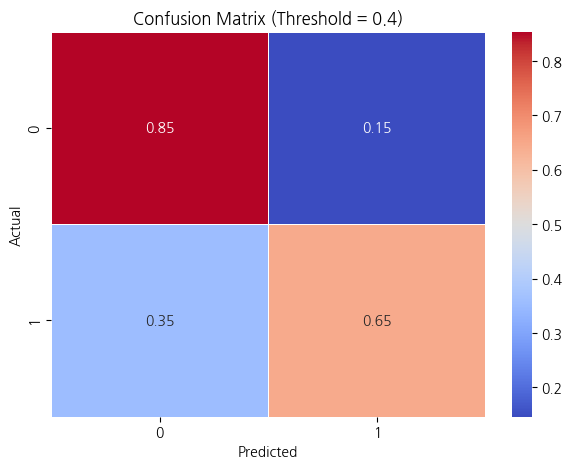

In [38]:
# 1️⃣ 모델 예측 확률 가져오기
y_pred = model_lgbm_V2.predict_proba(X_te)[:, 1]  # 1일 확률 (이탈 확률)

y_te = y_te.map({'No': 0, 'Yes': 1})
# 2️⃣ AUC 계산
fpr, tpr, thresholds = roc_curve(y_te, y_pred)
auc_te = auc(fpr, tpr)
print(f'{model_lgbm_V2}: AUC = {auc_te:.4f}')

# 3️⃣ Threshold 조정 후 새로운 예측값 생성
threshold = 0.4  # 기본 0.5에서 0.4로 조정
y_pred_class = (y_pred >= threshold).astype(int)

# 4️⃣ 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 5️⃣ 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

In [39]:
ori_te_pred = model_lgbm_V2.predict_proba(ori_te)[:,1]
ori_te_pred.shape

(1409,)

In [40]:
# 중요도 확인
df_feature_importances = pd.DataFrame(model_lgbm_V2.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

(23, 2)


,index,0
0,MonthlyCharges,825
1,TotalCharges,742
2,tenure,443
3,Contract,108
4,gender,98
5,PaperlessBilling,89
6,OnlineBackup,73
7,OnlineSecurity,68
8,AutoPayment,68
9,MultipleLines,60


In [41]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgbm,
        'score_te': score_te_lgbm,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [42]:
df_results = pd.DataFrame(args.results).assign(
    score_diff=lambda df: abs(df['score_tr'] - df['score_te']),  # Train-Test 차이 계산
    auc_diff=lambda df: abs(df['score_te'] - df['auc_te']),  # Test-AUC 차이 계산
    total_diff=lambda df: abs(df['score_tr'] - df['score_te']) + abs(df['score_te'] - df['auc_te'])  # 전체 차이
).sort_values(by=['total_diff', 'auc_te'], ascending=[True, False])

df_results

,model,parameters,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt,score_diff,auc_diff,total_diff
0,model_lgbm_V2,{'random_state': 42},0.897271,0.809228,0.843706,"[0.005360166204091349, 0.9331098510075301, 0.0...",23,"[MonthlyCharges, TotalCharges, tenure, Contrac...",2025-03-04 10:46:36,0.088043,0.034478,0.122521
